Warnings suppressed for cleaner output

╔══════════════════════════════════════════════════════════╗
║    MITOFUSIONAI - FDA DRUG PREDICTION (SDF VERSION)     ║
║    Scaffold-Split AUC: 0.783 | Mitochondrial Fusion     ║
╚══════════════════════════════════════════════════════════╝


[1/7] LOADING TRAINED MODEL...
Model loaded: phase1_model.pkl

[2/7] LOADING FDA DRUGS FROM SDF...
Loaded 1399 compounds from 'fda_drugs.sdf'

 SDF contains 46 columns:
      - DATABASE_ID
      - DATABASE_NAME
      - ORIGINAL_SOURCE
      - ORIGINAL_SOURCE_URL
      - SMILES
      - INCHI_IDENTIFIER
      - INCHI_KEY
      - FORMULA
      - MOLECULAR_WEIGHT
      - EXACT_MASS
      - JCHEM_ACCEPTOR_COUNT
      - JCHEM_ATOM_COUNT
      - JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE
      - JCHEM_AVERAGE_POLARIZABILITY
      - JCHEM_BIOAVAILABILITY
      ... and 31 more

 Using SMILES from column: 'SMILES'
 Using name column: 'ID'

[3/7] CONVERTING TO FINGERPRINTS...
   Converting 1399 drugs to fingerprints...

   Progress:   0%|                                                                                                                                                                 | 0/1399 [00:00<?, ?it/s][01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNING: please use MorganGenerator
[01:14:49] DEPRECATION WARNIN

   Successfully converted 1399/1399 drugs
   Failed: 0 (invalid SMILES)

[4/7]  MAKING PREDICTIONS...
 Predictions complete for 1399 drugs

[5/7] CREATING RESULTS TABLE...
 Added property: INCHI_KEY
 Added property: FORMULA
 Added property: EXACT_MASS
Full results saved: 'fda_predictions_full.csv'
Top 100 saved: 'fda_predictions_top100.csv'

[6/7] CALCULATING MOLECULAR PROPERTIES...
   Calculating molecular properties...


   Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1399/1399 [00:00<00:00, 2330.70it/s]


Added molecular descriptors and CNS permeability prediction
Enriched results saved: 'fda_predictions_enriched.csv'

[7/7] GENERATING FINAL REPORTS...

TOP 20 FDA DRUGS PREDICTED TO INHIBIT MITOCHONDRIAL FUSION
# 1 0.960 ★★★★     5568
# 2 0.948 ★★★★     2726
# 3 0.932 ★★★★     5566
# 4 0.926 ★★★★  CNS 3372
# 5 0.926 ★★★★  CNS 4917
# 6 0.910 ★★★★  CNS 7547
# 7 0.909 ★★★★  CNS 4748
# 8 0.907 ★★★★  CNS 4926
# 9 0.904 ★★★★     4078
#10 0.902 ★★★★     5574
#11 0.900 ★★★★     107970
#12 0.894 ★★★★     2801
#13 0.892 ★★★★  CNS 72287
#14 0.892 ★★★★     4744
#15 0.890 ★★★★     3610
#16 0.884 ★★★★  CNS 3149
#17 0.880 ★★★★     26987
#18 0.879 ★★★★     4927
#19 0.876 ★★★★  CNS 62582
#20 0.874 ★★★★  CNS 2564

PREDICTION STATISTICS
Total drugs predicted: 1,399
Mean probability: 0.348
Median probability: 0.300
CNS-penetrant candidates: 867 (62.0%)

High-confidence candidates (p > 0.8): 41
Very high-confidence (p > 0.9): 10

 Visualization saved: 'fda_predictions_comprehensive.png'

PREDICTION PIPELINE

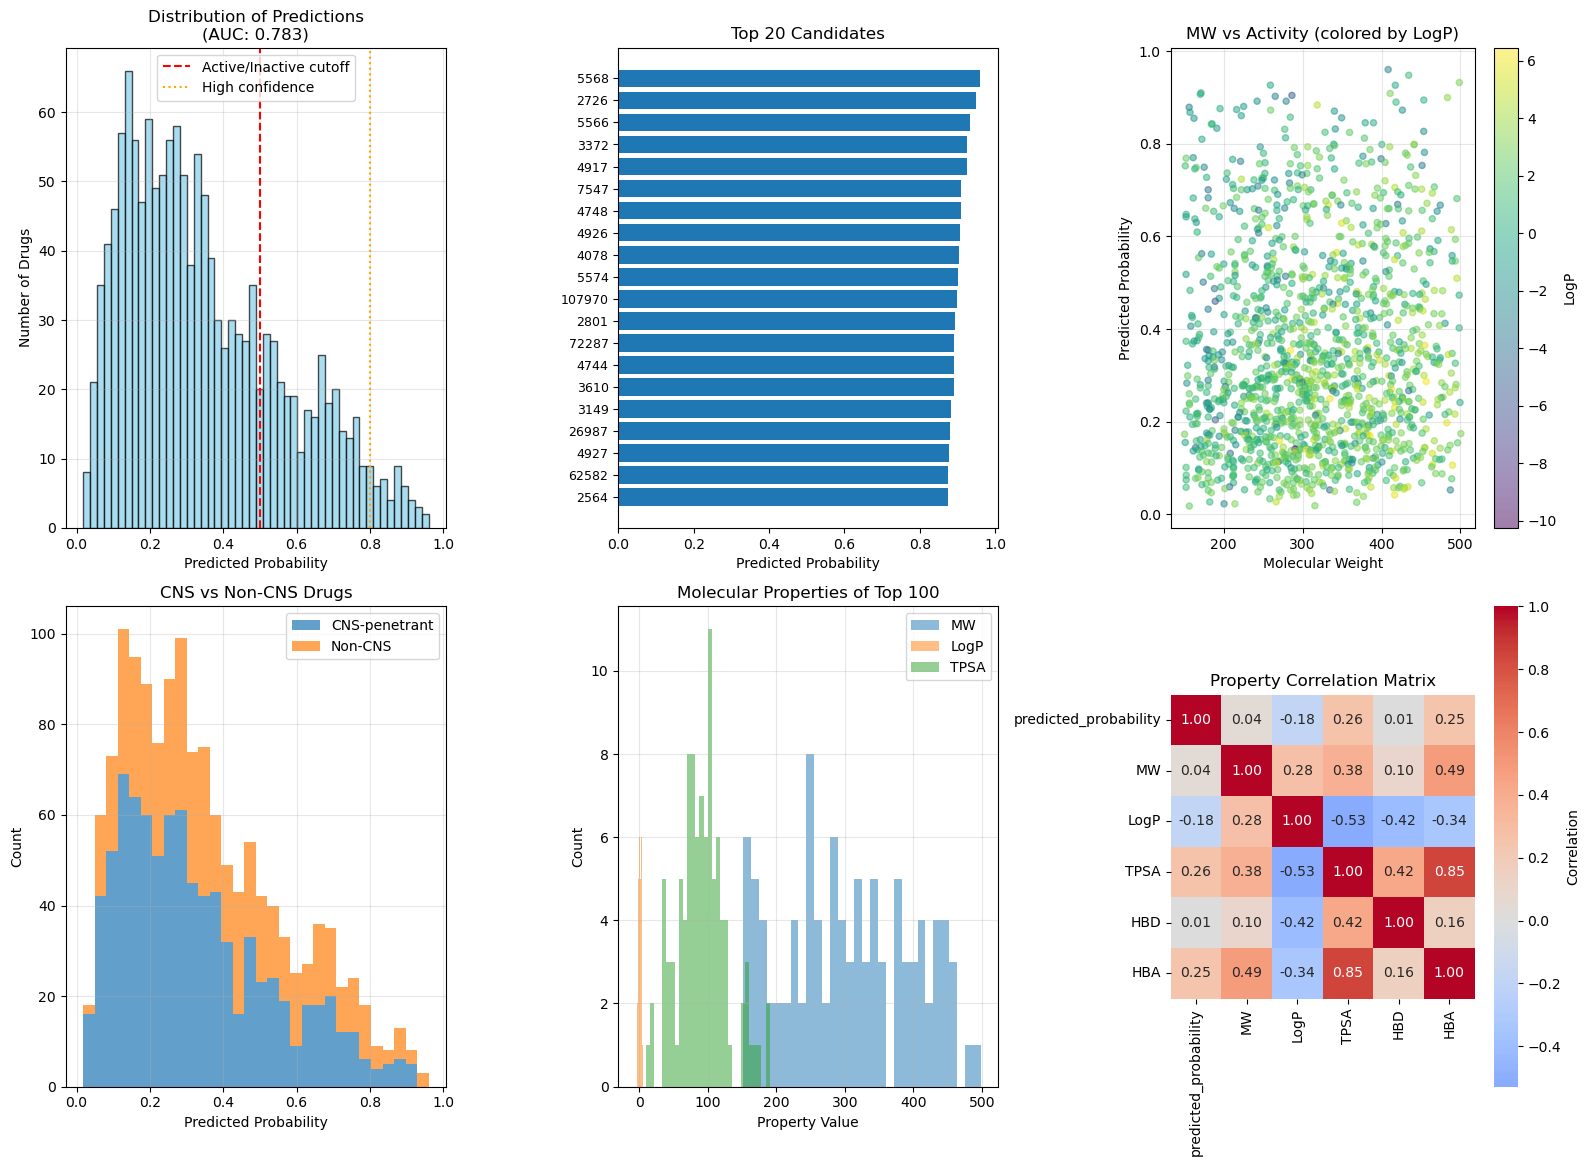

In [3]:
# ==================== SUPPRESS WARNINGS ====================
import warnings
warnings.filterwarnings('ignore')

# Suppress RDKit warnings specifically
import logging
logging.getLogger('rdkit').setLevel(logging.ERROR)

# Optional: Suppress XGBoost warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings if any

print("Warnings suppressed for cleaner output")

# predict_FDA_approved_activity_against_Mfusion.py
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("""
╔══════════════════════════════════════════════════════════╗
║    MITOFUSIONAI - FDA DRUG PREDICTION                    ║
║    Scaffold-Split AUC: 0.783 | Mitochondrial Fusion      ║
╚══════════════════════════════════════════════════════════╝
""")

# ==================== 1. LOAD MODEL ====================
print("\n[1/7] LOADING TRAINED MODEL...")
try:
    model = joblib.load('phase1_model.pkl')
    print("Model loaded: phase1_model.pkl")
except:
    print("ERROR: Could not load phase1_model.pkl")
    print("Make sure you ran train_scaffold_model.py first!")
    exit()

# ==================== 2. LOAD SDF FILE ====================
print("\n[2/7] LOADING FDA DRUGS FROM SDF...")
# UPDATE THIS TO YOUR ACTUAL SDF FILENAME
SDF_FILE = "fda_drugs.sdf"  

try:
    # Load SDF into pandas DataFrame with RDKit molecules
    sdf_df = PandasTools.LoadSDF(SDF_FILE, 
                                 smilesName='SMILES',
                                 molColName='Molecule',
                                 includeFingerprints=False)
    
    print(f"Loaded {len(sdf_df)} compounds from '{SDF_FILE}'")
    
    # Check what columns we have
    print(f"\n SDF contains {len(sdf_df.columns)} columns:")
    for col in sdf_df.columns[:15]:  # Show first 15 columns
        print(f"      - {col}")
    if len(sdf_df.columns) > 15:
        print(f"      ... and {len(sdf_df.columns) - 15} more")
    
    # Check for SMILES column
    if 'SMILES' not in sdf_df.columns:
        print("No 'SMILES' column found, checking alternatives...")
        for col in sdf_df.columns:
            if 'smiles' in col.lower():
                sdf_df.rename(columns={col: 'SMILES'}, inplace=True)
                print(f" Renamed '{col}' to 'SMILES'")
                break
    
    if 'SMILES' not in sdf_df.columns:
        print("ERROR: No SMILES data found in SDF!")
        exit()
    
    print(f"\n Using SMILES from column: 'SMILES'")
    
    # Check for drug name column
    name_col = None
    possible_names = ['Name', 'DRUG_NAME', 'Generic_Name', 'TRADE_NAME', 
                      'COMMON_NAME', 'COMPOUND_NAME', 'ID']
    for col in possible_names:
        if col in sdf_df.columns:
            name_col = col
            break
    
    if name_col:
        print(f" Using name column: '{name_col}'")
    else:
        print("No standard name column found")
        # Create a name from available columns
        if 'ID' in sdf_df.columns:
            sdf_df['drug_name'] = 'Drug_' + sdf_df['ID'].astype(str)
            name_col = 'drug_name'
        else:
            sdf_df['drug_name'] = [f"Drug_{i}" for i in range(len(sdf_df))]
            name_col = 'drug_name'
        print(f"Created synthetic name column")
    
except Exception as e:
    print(f"   ERROR loading {SDF_FILE}: {str(e)[:100]}...")
    print(f"   Full error: {e}")
    exit()

# ==================== 3. CONVERT TO FINGERPRINTS ====================
print("\n[3/7] CONVERTING TO FINGERPRINTS...")

def smiles_to_fp(smiles):
    """Convert SMILES to Morgan fingerprint (1024 bits)"""
    try:
        mol = Chem.MolFromSmiles(str(smiles))
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return list(fp)
    except:
        return None

# Convert with progress bar
print(f"   Converting {len(sdf_df)} drugs to fingerprints...")
fingerprints = []
valid_indices = []
drug_names = []
smiles_list = []

for idx, row in tqdm(sdf_df.iterrows(), total=len(sdf_df), desc="   Progress"):
    smiles = row['SMILES']
    name = row[name_col] if pd.notna(row[name_col]) else f"Drug_{idx}"
    
    fp = smiles_to_fp(smiles)
    if fp is not None:
        fingerprints.append(fp)
        valid_indices.append(idx)
        drug_names.append(name)
        smiles_list.append(smiles)

print(f"   Successfully converted {len(fingerprints)}/{len(sdf_df)} drugs")
print(f"   Failed: {len(sdf_df) - len(fingerprints)} (invalid SMILES)")

if len(fingerprints) < 10:
    print("RROR: Too few valid drugs!")
    print("Check your SDF file format and SMILES column")
    exit()

# ==================== 4. MAKE PREDICTIONS ====================
print("\n[4/7]  MAKING PREDICTIONS...")

X_fda = pd.DataFrame(fingerprints)
predictions = model.predict_proba(X_fda)[:, 1]  # Probability of being active

print(f" Predictions complete for {len(predictions)} drugs")

# ==================== 5. CREATE RESULTS ====================
print("\n[5/7] CREATING RESULTS TABLE...")

# Create comprehensive results dataframe
results = pd.DataFrame({
    'rank': np.arange(1, len(predictions) + 1),
    'drug_name': drug_names,
    'smiles': smiles_list,
    'predicted_probability': predictions,
    'predicted_class': (predictions >= 0.5).astype(int),
    'confidence': np.abs(predictions - 0.5) * 2  # 0-1 scale
})

# Add important SDF properties if available
important_props = ['Molecular_Weight', 'ALOGP', 'CAS_Number', 'DrugBank_ID',
                   'INCHI_KEY', 'FORMULA', 'EXACT_MASS', 'CHARGE']

for prop in important_props:
    if prop in sdf_df.columns:
        results[prop] = sdf_df.iloc[valid_indices][prop].values
        print(f" Added property: {prop}")

# Sort by probability (highest first)
results = results.sort_values('predicted_probability', ascending=False)
results['rank'] = np.arange(1, len(results) + 1)

# Save full results
results.to_csv('fda_predictions_full.csv', index=False)
print("Full results saved: 'fda_predictions_full.csv'")

# Save top 100
top_100 = results.head(100)
top_100.to_csv('fda_predictions_top100.csv', index=False)
print("Top 100 saved: 'fda_predictions_top100.csv'")

# ==================== 6. ADD MOLECULAR PROPERTIES ====================
print("\n[6/7] CALCULATING MOLECULAR PROPERTIES...")

def calculate_descriptors(smiles):
    """Calculate key molecular descriptors"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 6
    
    from rdkit.Chem import Descriptors, Lipinski
    from rdkit.Chem.Crippen import MolLogP
    from rdkit.Chem.rdMolDescriptors import CalcTPSA
    
    return [
        Descriptors.MolWt(mol),                    # Molecular weight
        MolLogP(mol),                              # LogP
        CalcTPSA(mol),                             # Polar surface area
        Lipinski.NumHDonors(mol),                  # H-bond donors
        Lipinski.NumHAcceptors(mol),               # H-bond acceptors
        Lipinski.NumRotatableBonds(mol),           # Rotatable bonds
    ]

print("   Calculating molecular properties...")
descriptors = []
for smiles in tqdm(results['smiles'], desc="   Progress"):
    descriptors.append(calculate_descriptors(smiles))

desc_df = pd.DataFrame(descriptors, columns=['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds'])
results = pd.concat([results, desc_df], axis=1)

# Add CNS permeability prediction (Rule of 5 for CNS)
results['CNS_permeable'] = (
    (results['MW'] <= 450) & 
    (results['LogP'] <= 5) & 
    (results['HBD'] <= 3) & 
    (results['TPSA'] <= 90)
).astype(int)

print("Added molecular descriptors and CNS permeability prediction")

# Save enriched results
results.to_csv('fda_predictions_enriched.csv', index=False)
print("Enriched results saved: 'fda_predictions_enriched.csv'")

# ==================== 7. VISUALIZE & REPORT ====================
print("\n[7/7] GENERATING FINAL REPORTS...")

# 7.1 Top 20 predictions
print("\n" + "="*90)
print("TOP 20 FDA DRUGS PREDICTED TO INHIBIT MITOCHONDRIAL FUSION")
print("="*90)
top_20 = results.head(20)
for idx, row in top_20.iterrows():
    prob = row['predicted_probability']
    name = row['drug_name']
    cns = "CNS" if row.get('CNS_permeable', 0) == 1 else "  "
    stars = "★" * min(int(prob * 5), 5)
    print(f"#{row['rank']:2d} {prob:.3f} {stars:5s} {cns} {name}")

# 7.2 Statistics
print("\n" + "="*90)
print("PREDICTION STATISTICS")
print("="*90)
print(f"Total drugs predicted: {len(results):,}")
print(f"Mean probability: {results['predicted_probability'].mean():.3f}")
print(f"Median probability: {results['predicted_probability'].median():.3f}")
print(f"CNS-penetrant candidates: {results['CNS_permeable'].sum():,} ({results['CNS_permeable'].sum()/len(results)*100:.1f}%)")
print(f"\nHigh-confidence candidates (p > 0.8): {(results['predicted_probability'] > 0.8).sum():,}")
print(f"Very high-confidence (p > 0.9): {(results['predicted_probability'] > 0.9).sum():,}")

# 7.3 Visualization
plt.figure(figsize=(16, 12))

# Plot 1: Distribution of predictions
plt.subplot(2, 3, 1)
plt.hist(results['predicted_probability'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Active/Inactive cutoff')
plt.axvline(x=0.8, color='orange', linestyle=':', label='High confidence')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Drugs')
plt.title('Distribution of Predictions\n(AUC: 0.783)')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Top 20 drugs (horizontal bar)
plt.subplot(2, 3, 2)
top_20_plot = results.head(20)
y_pos = np.arange(len(top_20_plot))
plt.barh(y_pos, top_20_plot['predicted_probability'])
plt.yticks(y_pos, top_20_plot['drug_name'], fontsize=9)
plt.xlabel('Predicted Probability')
plt.title('Top 20 Candidates')
plt.gca().invert_yaxis()

# Plot 3: Molecular weight vs probability
plt.subplot(2, 3, 3)
plt.scatter(results['MW'], results['predicted_probability'], 
           alpha=0.5, s=20, c=results['LogP'], cmap='viridis')
plt.colorbar(label='LogP')
plt.xlabel('Molecular Weight')
plt.ylabel('Predicted Probability')
plt.title('MW vs Activity (colored by LogP)')
plt.grid(alpha=0.3)

# Plot 4: CNS-penetrant candidates
plt.subplot(2, 3, 4)
cns_drugs = results[results['CNS_permeable'] == 1]
non_cns = results[results['CNS_permeable'] == 0]
plt.hist([cns_drugs['predicted_probability'], non_cns['predicted_probability']], 
         bins=30, label=['CNS-penetrant', 'Non-CNS'], alpha=0.7, stacked=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('CNS vs Non-CNS Drugs')
plt.legend()
plt.grid(alpha=0.3)

# Plot 5: Property distribution of top candidates
plt.subplot(2, 3, 5)
top_100 = results.head(100)
properties = ['MW', 'LogP', 'TPSA']
for i, prop in enumerate(properties):
    plt.hist(top_100[prop].dropna(), bins=30, alpha=0.5, label=prop)
plt.xlabel('Property Value')
plt.ylabel('Count')
plt.title('Molecular Properties of Top 100')
plt.legend()
plt.grid(alpha=0.3)

# Plot 6: Correlation heatmap (if enough properties)
plt.subplot(2, 3, 6)
corr_cols = ['predicted_probability', 'MW', 'LogP', 'TPSA', 'HBD', 'HBA']
corr_data = results[corr_cols].corr()
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, cbar_kws={'label': 'Correlation'})
plt.title('Property Correlation Matrix')

plt.tight_layout()
plt.savefig('fda_predictions_comprehensive.png', dpi=300, bbox_inches='tight')
print("\n Visualization saved: 'fda_predictions_comprehensive.png'")

# 7.4 Save detailed report
with open('prediction_report.md', 'w') as f:
    f.write("# MITOFUSIONAI - FDA Drug Prediction Report\n\n")
    f.write(f"**Generated**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"**Model AUC**: 0.783 (scaffold-split validation)\n")
    f.write(f"**Total FDA drugs analyzed**: {len(results):,}\n")
    f.write(f"**SDF Source**: {SDF_FILE}\n\n")
    
    f.write("## Top 20 Candidates\n\n")
    f.write("| Rank | Drug Name | Probability | CNS-Permeable |\n")
    f.write("|------|-----------|-------------|---------------|\n")
    for idx, row in results.head(20).iterrows():
        cns = "YES" if row['CNS_permeable'] == 1 else "NO"
        f.write(f"| {row['rank']} | {row['drug_name']} | {row['predicted_probability']:.3f} | {cns} |\n")
    
    f.write("\n## Key Statistics\n\n")
    f.write(f"- **High-confidence candidates (p > 0.8)**: {(results['predicted_probability'] > 0.8).sum():,}\n")
    f.write(f"- **CNS-penetrant candidates**: {results['CNS_permeable'].sum():,}\n")
    f.write(f"- **Average molecular weight**: {results['MW'].mean():.1f} Da\n")
    f.write(f"- **Average LogP**: {results['LogP'].mean():.2f}\n")
    
    f.write("\n## Recommended Validation Strategy\n\n")
    f.write("1. **Top 5 candidates**: Experimental validation in mitochondrial fusion assay\n")
    f.write("2. **CNS-penetrant candidates (p > 0.7)**: Prioritize for neurodegenerative disease applications\n")
    f.write("3. **Literature review**: Check PubMed for mitochondrial effects of top 20\n")
    f.write("4. **Safety profile**: Check known side effects and contraindications\n")

print("\n" + "="*90)
print("PREDICTION PIPELINE COMPLETE!")
print("="*90)
print("\n FILES GENERATED:")
print("   1. fda_predictions_full.csv       - All predictions with SMILES")
print("   2. fda_predictions_enriched.csv   - With molecular properties")
print("   3. fda_predictions_top100.csv     - Top 100 candidates")
print("   4. fda_predictions_comprehensive.png - Visualization")
print("   5. prediction_report.md           - Detailed report")
print("\n IMMEDIATE NEXT STEPS:")
print("   1. Check the TOP 20 LIST above")
print("   2. Open fda_predictions_enriched.csv")
print("   3. Filter for CNS_permeable = 1 AND predicted_probability > 0.7")
print("   4. Research these candidates in PubMed")
print("\n PRIORITY CHECKLIST:")
print("   [ ] 1. Any known mitochondrial drugs in top 20? (Validates model)")
print("   [ ] 2. Any drugs already used for neurological conditions?")
print("   [ ] 3. Any with known fusion/fission effects?")
print("   [ ] 4. Safety profiles of top candidates?")
print("="*90)

# Show filtered CNS-penetrant candidates
cns_candidates = results[(results['CNS_permeable'] == 1) & 
                         (results['predicted_probability'] > 0.7)]
if len(cns_candidates) > 0:
    print(f"\n PRIORITY CANDIDATES (CNS-penetrant & p > 0.7): {len(cns_candidates)} drugs")
    for idx, row in cns_candidates.head(10).iterrows():
        print(f"   #{row['rank']:3d} {row['predicted_probability']:.3f} - {row['drug_name']}")